# Group Project Proposal
**Section 6 | Group 3**

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

**Introduction**

   Heart disease has become one of the leading causes of death, occupying a fifth of American deaths in 2020. As such, we must educate ourselves and become aware of the several possible factors that may lead to cardiovascular diseases. One of the main causes of heart disease is high blood pressure. It is known to decrease blood and oxygen supply to the heart, which can lead to heart attacks or heart failure (https://www.cdc.gov/bloodpressure/about.htm). Given that heart disease can still occur in individuals deemed healthy and young, age is still a factor that increases the likelihood that someone may encounter heart problems (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6616540/). Similarly, the association seen between age, cholesterol levels, obesity, and several other health concerns suggests that a combined effect between these factors play a roll in increasing the risk of getting heard disease (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6616540/). Simply put, there is an evident correlation between age, blood pressure, and cholesterol levels with cardiovascular diseases. We decided to study the combined affect of these three factors on the presence of heart disease. *Given a patient’s resting blood pressure, age, and blood cholesterol levels, are the likely to have heart disease or not?*
    
   (https://canvas.ubc.ca/courses/106510/assignments/1419852?module_item_id=5168273)
   This is the Cleveland dataset from the “Heart Disease Data Set” on the UCI Machine Learning Repository, which conducted analysis on 303 participants to measure different predictors as well as the presence/absence of heart disease in 1988. The project identified 14 attributes as its columns, such as the age and sex of participants, as well as predictors including their resting heart pressure, blood cholesterol levels, and chest pain type. There was also the predicted attribute column with values ranging from 0 (no heart disease), to 4 (1, 2, 3 and 4 all referring to the presence of heart disease). The study’s goal was to look at the relationship between the 13 predictors and the presence/absence of heart disease. 


**Preliminary Exloratory Data Analysis**

In [2]:
# reading in data
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
heart <- read_delim(url, delim = ",", 
                    col_names=c("age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","predicted_attribute"))
head(heart)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,predicted_attribute
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


Table 1

Cleaning and wrangling data:

Selecting only the columns we will be using and changing column names to make more sense. We will only be using the columns for age, resting blood pressure (mm Hg), cholesterol (mg/dl), and the heart disease diagnosis (yes or no). 

In [3]:
heart_clean <- select(heart, "age", "trestbps", "chol", "predicted_attribute")
colnames(heart_clean) <- c("age","blood_pressure","cholesterol","heart_diagnosis")
head(heart_clean)

age,blood_pressure,cholesterol,heart_diagnosis
<dbl>,<dbl>,<dbl>,<dbl>
63,145,233,0
67,160,286,2
67,120,229,1
37,130,250,0
41,130,204,0
56,120,236,0


Table 2

heart_diagnosis has observations 0, 1, 2, 3, and 4, 

0 equates to the absence of heart disease (i.e. less than 50% vessel narrowing)

1-4 all equate to the presence of heart disease (i.e. more than 50% vessel narrowing).

Compile numbers 1-4 to equal "yes" for presence of heart disease and 
0 to equal "no" for the absence of heart disease. The heart disease diagnosis is changed to a factor.

In [4]:
heart_filter <- filter(heart_clean, heart_diagnosis == 1 | heart_diagnosis == 2 | heart_diagnosis == 3 |heart_diagnosis == 4)|>
    mutate(heart_diagnosis = "yes")
heart_data <- filter(heart_clean, heart_diagnosis == 0)|>
    mutate(heart_diagnosis = "no")|>
    bind_rows(heart_filter)|>
    mutate(heart_diagnosis = as.factor(heart_diagnosis))
head(heart_data)

age,blood_pressure,cholesterol,heart_diagnosis
<dbl>,<dbl>,<dbl>,<fct>
63,145,233,no
37,130,250,no
41,130,204,no
56,120,236,no
57,120,354,no
57,140,192,no


splitting data into a training set and testing set

Table 3

In [5]:
heart_split <- initial_split(heart_data, prop = 0.75, strata = heart_diagnosis)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

Summarize data in table

Average age, blood pressure, and cholesterol level for each heart disease class.

Count number of individuals with and without heart disease

In [6]:
heart_summary <- heart_training |>
    group_by(heart_diagnosis)|>
    summarize(average_age = mean(age), 
              average_bp = mean(blood_pressure),
              average_c = mean(cholesterol))
heart_summary

heart_diagnosis,average_age,average_bp,average_c
<fct>,<dbl>,<dbl>,<dbl>
no,52.34146,128.4390,243.0407
yes,56.94231,135.2596,251.3173


Table 4

In [7]:
heart_count <- heart_training |>
    group_by(heart_diagnosis)|>
    summarize(count = n())
heart_count

heart_diagnosis,count
<fct>,<int>
no,123
yes,104


Table 5

Data visualizations

Plotted Age agaisnt cholesterol with the heart diagnosis as the colour.
This was only to explore the training data, we will examine all three predictors against heart diagnosis during the actual analysis.

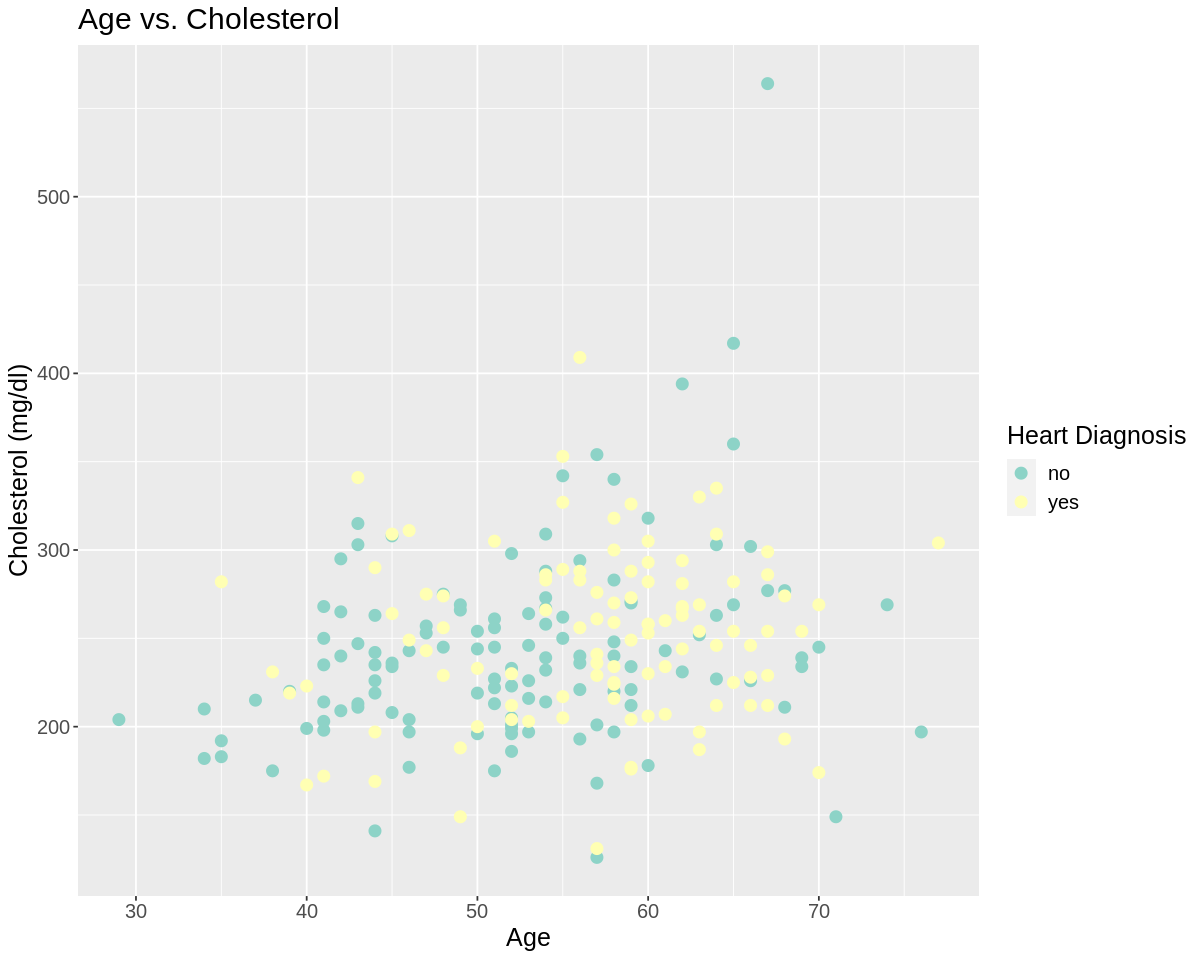

In [8]:
options(repr.plot.width = 10, repr.plot.height = 8)
Age_Cholesterol_plot <- heart_training |>
    ggplot(aes(x = age, y = cholesterol, color = heart_diagnosis)) +
    geom_point(size = 3) +
    labs(x = "Age", y = "Cholesterol (mg/dl)", color = "Heart Diagnosis") +
    theme(text = element_text(size = 15)) +
    scale_color_brewer(palette = "Set3") +
    ggtitle("Age vs. Cholesterol")

Age_Cholesterol_plot

Graph 1

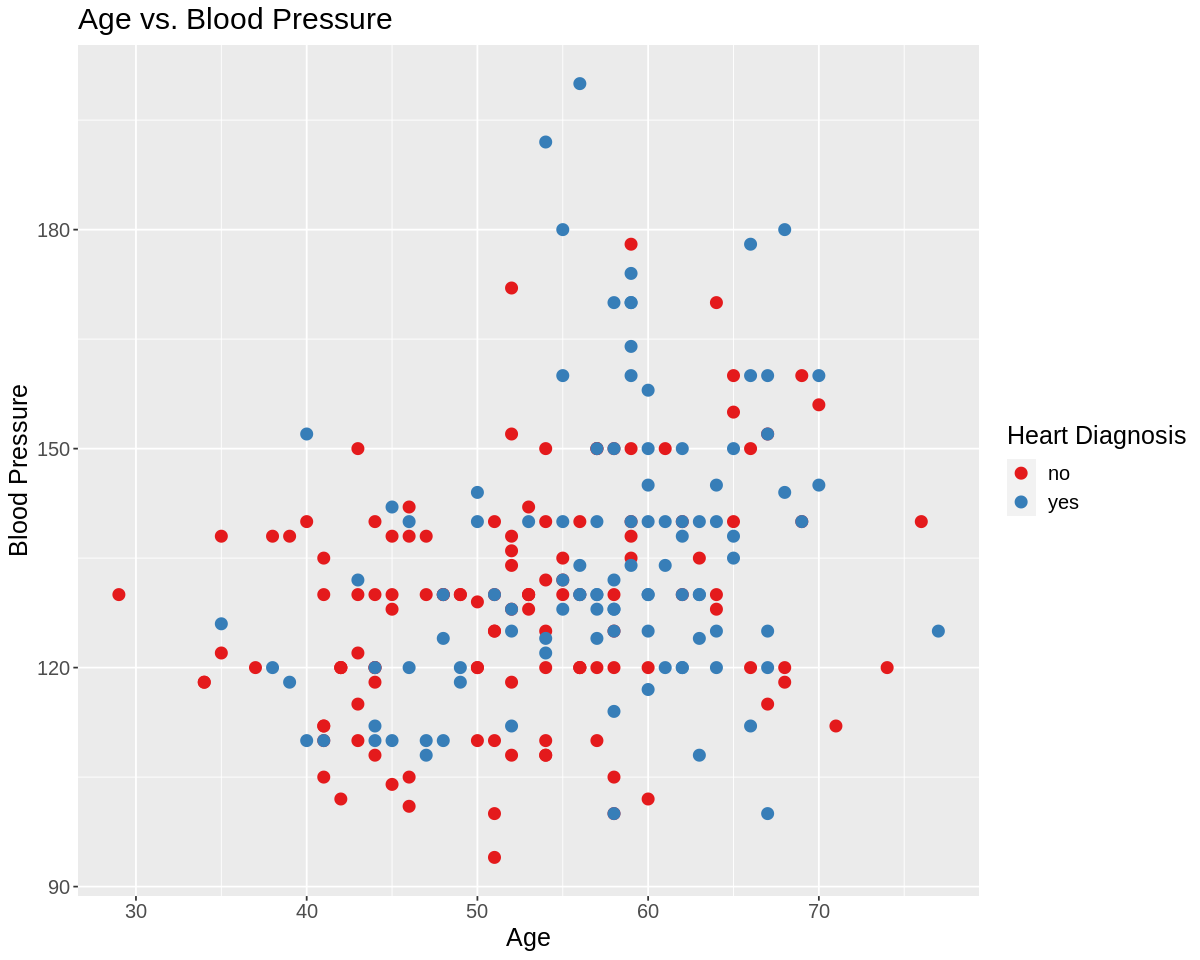

In [9]:
options(repr.plot.width = 10, repr.plot.height = 8)
Age_BloodPressure_plot <- heart_training |>
    ggplot(aes(x = age, y = blood_pressure, color = heart_diagnosis)) +
    geom_point(size = 3) +
    labs(x = "Age", y = "Blood Pressure", color = "Heart Diagnosis") +
    theme(text = element_text(size = 15)) +
    scale_color_brewer(palette = "Set1") +
    ggtitle("Age vs. Blood Pressure")

Age_BloodPressure_plot

Graph 2

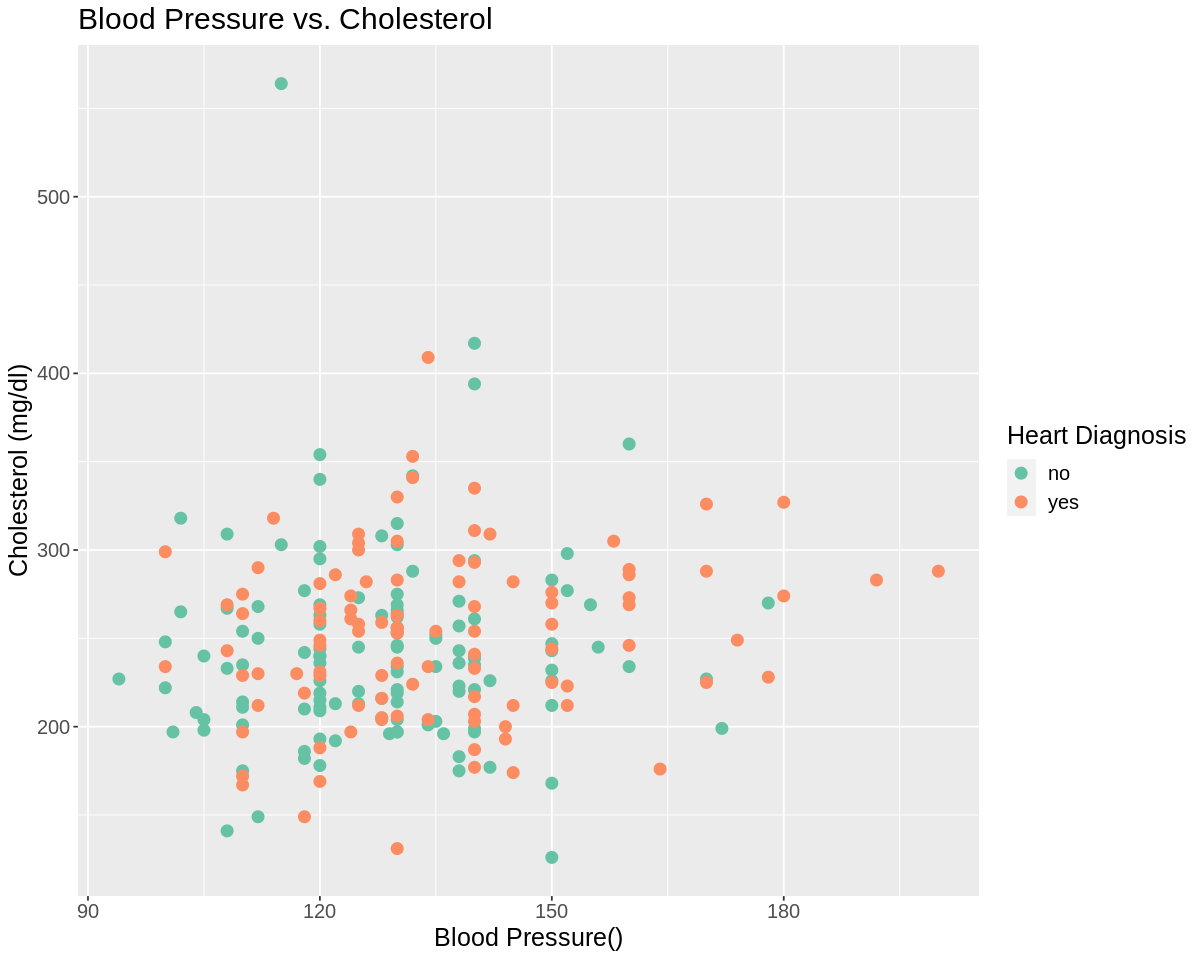

In [10]:
options(repr.plot.width = 10, repr.plot.height = 8)
BloodPressure_Cholesterol_plot <- heart_training |>
    ggplot(aes(x = blood_pressure, y = cholesterol, color = heart_diagnosis)) +
    geom_point(size = 3) +
    labs(x = "Blood Pressure()", y = "Cholesterol (mg/dl)", color = "Heart Diagnosis") +
    theme(text = element_text(size = 15)) +
    scale_color_brewer(palette = "Set2") +
    ggtitle("Blood Pressure vs. Cholesterol")

BloodPressure_Cholesterol_plot

Graph 3

**Methods:**

We will be using the following columns, chosen based on the research outlined in the introduction: serum cholesterol levels (chol)(mg/dl); age (years); resting blood pressure (mm Hg), and the predictive class (presence/absence of heart disease). The steps we will take to visualize our results to the question on whether or not these predictors accurately anticipate the presence/absence of heart disease are:
1. We will first split our data into training and testing data by (75% training, 25% testing)
2. We will then scale and center the data to ensure our predictors are on a comparable scale
3. Next, we will create our classification model using the training data

    a. This will be a K-nearest neighbor classification 
    
    b. We will need to pick the best K by using cross-validation (splitting training data into training and evaluating/validation data)
    
    c. After choosing the most accurate K, we will perform a K-nearest neighbor 
           classification on our testing data using the model
4. We will then visualize our results in a few ways:

    a. Visualizing our model, we will create a graph comparing the different predictors (on the axis) and colored by classification (presence/absence of heart disease)
    
    b. We will then fit our testing data (plotting it) against the predictors to represent the predictions using the model.
    
5. Our final step will be evaluating the accuracy of our model in terms of its ability to classify the testing data

    a. We will do this by calculating our prediction accuracy (total number of correct predictions divided by total number of predictions (testing data))
    
    b. We will also create a scatterplot that compares the predicted values and the observed values for this training data to visualize the accuracy of our model


**Expected outcomes and significance:**

We expect to find that these predictors (age, resting blood pressure, cholesterol) are able to accurately predict if a patient has heart disease or not. These findings could have implications for the health industry in that knowing that these specific values/predictors are able to anticipate the presence of heart disease can offer further insight into the health of populations. For instance, it could prove that tracking a population’s cholesterol and age could also aid in predicting that population’s heart health without having to specifically target that. As such, it opens up possibilities for health consensus and predicting if certain classes of people will be more susceptible to this disease. Moreover, these findings could lead to further questions such as if there is a correlation between these predictors and heart disease (i.e. older age and presence of heart disease), and possibly the reasons behind this (i.e. investigating how age affects heart health).

